In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json

def is_standard_sample_size(size):
    # Convert to string
    size_str = str(int(size))

    patterns = [
        r'^(1|5)0{3,}$',
        r'^(2|3|4)0{6,}$' 
    ]
    
    # Check if the size matches any pattern
    return any(re.match(pattern, size_str) for pattern in patterns)

small_datasets = set(["zcta5", "aerowaythingnodesorted", "craftwaysorted", "arealm", "emergencythingwaysorted", "historicthingwaysorted", "aerowaythingwaysorted"])
big_datasets = set(['powerthingnodesorted', 'yago2', 'powerthingwaysorted', 'barrierthingwaysorted', 'cyclewaythingwaysorted', 'areawater', 'leisurewaysorted'])

def is_small_dataset(dataset_name):    
    return dataset_name in small_datasets

def is_big_dataset(dataset_name):
    return dataset_name in big_datasets

In [18]:
def plot_method_performance_comparison_mean_std(methods_dir, metric='MAE', figsize=(12, 8), 
                                      std_dev_alpha=0.2, log_scale=True,
                                      title=None, save_path=None, filter_type_='contain', rh_json="rtree_histogram.json",
                                      dataset_filter_type=0):
        """
        Create a plot comparing methods' performance across different sample sizes,
        with variance shown as shaded areas.
        
        Args:
            methods_dir: Directory containing method folders
            metric: Performance metric to use ('MAE', 'MAPE', 'R2_Score', etc.)
            figsize: Figure size (width, height)
            std_dev_alpha: Alpha transparency for the standard deviation shading
            log_scale: Whether to use logarithmic scale for x and/or y axes
            title: Custom title (if None, generates based on metric)
            save_path: Path to save the figure
            
        Returns:
            matplotlib Figure and Axes
        """
        # Get all method directories
        method_dirs = [d for d in os.listdir(methods_dir) 
                    if os.path.isdir(os.path.join(methods_dir, d))]
        
        # Prepare data collection
        all_data = []
        
        # Process each method
        for method in method_dirs:
            method_path = os.path.join(methods_dir, method)
            results_file = os.path.join(method_path, 'all_results.csv')
            
            if not os.path.exists(results_file):
                print(f"Warning: No all_results.csv found for method {method}")
                continue
            
            # Read the method's data
            try:
                df = pd.read_csv(results_file)
                
                # Add method column
                df['Method'] = method if method != 'NN' else 'MLP'
                
                # Append to collection
                all_data.append(df)
                
            except Exception as e:
                print(f"Error reading data for method {method}: {e}")
        
        if not all_data:
            raise ValueError("No valid data found in the method directories")
        
        # Combine all data
        combined_df = pd.concat(all_data, ignore_index=True)
        
        filtered_df = combined_df[combined_df['Sample_Size'].apply(is_standard_sample_size)]

        if dataset_filter_type == 1:
            filtered_df = filtered_df[filtered_df['Dataset'].apply(is_big_dataset)]
        elif dataset_filter_type == 2:
            filtered_df = filtered_df[filtered_df['Dataset'].apply(is_small_dataset)]
        
        if filtered_df.empty:
            print("Warning: No data matches standard sample sizes. Using all available sizes.")
            print(f"Available sizes: {sorted(combined_df['Sample_Size'].unique())}")
            filtered_df = combined_df
        else:
            print(f"Using standard sample sizes: {sorted(filtered_df['Sample_Size'].unique())}")
        
        # Group by Method and Sample_Size to get mean and std
        grouped = filtered_df.groupby(['Method', 'Sample_Size']).agg({
            metric: ['mean', 'std']
        }).reset_index()
        
        # Flatten the multi-level columns
        grouped.columns = ['Method', 'Sample_Size', f'Mean_{metric}', f'Std_{metric}']
        
        # Create the plot
        plt.figure(figsize=figsize)
        sns.set_style('whitegrid')
        
        # Create a colorful palette
        methods = grouped['Method'].unique()
        palette = sns.color_palette('tab10', n_colors=len(methods)+2)

        sample_sizes = grouped['Sample_Size'].unique()
        
        # Plot for each method
        for i, method in enumerate(methods):
            # if method != 'XGB': continue
            if method == 'DT': continue

            method_data = grouped[grouped['Method'] == method]
            
            # Sort by sample size
            method_data = method_data.sort_values('Sample_Size')
            
            # Plot line and mean
            plt.plot(method_data['Sample_Size'], method_data[f'Mean_{metric}'], 
                    marker='o', linewidth=2.5, label=method, color=palette[i])
            
            # Add shaded area for variance
            if f'Std_{metric}' in method_data.columns:
                # print(method_data[f'Mean_{metric}'], method_data[f'Std_{metric}'])
                # upper = method_data[f'Mean_{metric}'] + method_data[f'Std_{metric}']
                # lower = method_data[f'Mean_{metric}'] - method_data[f'Std_{metric}']
                
                # Replace the upper/lower calculation
                upper = method_data[f'Mean_{metric}'] + method_data[f'Std_{metric}']
                lower = method_data[f'Mean_{metric}'] - method_data[f'Std_{metric}']
                # Ensure lower bound isn't negative for metrics where that doesn't make sense
                if metric in ['MAE', 'MAPE']:
                    lower = np.maximum(lower, 0)
                    
                plt.fill_between(method_data['Sample_Size'], lower, upper, 
                                alpha=std_dev_alpha, color=palette[i])
                
        with open(rh_json, 'r') as f:
            rtree_histogram = json.load(f)
            for i, method in enumerate(rtree_histogram[filter_type_]):
                plt.plot(sample_sizes, [rtree_histogram[filter_type_][method][f'avg_{metric.lower()}']] * len(sample_sizes), 
                    marker='o', linewidth=2.5, label=method, color=palette[-i])
                lower = [rtree_histogram[filter_type_][method][f'avg_{metric.lower()}'] - rtree_histogram[filter_type_][method][f'std_{metric.lower()}']] * len(sample_sizes)
                upper = [rtree_histogram[filter_type_][method][f'avg_{metric.lower()}'] + rtree_histogram[filter_type_][method][f'std_{metric.lower()}']] * len(sample_sizes)
                plt.fill_between(sample_sizes, lower, upper, 
                                alpha=std_dev_alpha, color=palette[-i])
                
        
        # Set logarithmic scale if requested
        if log_scale:
            plt.xscale('log')
            # if metric in ['MAE', 'MAPE']:  # Only use log y-scale for error metrics
            plt.yscale('log')
        
        # Set labels and title
        plt.xlabel('Learning Base Size', fontsize=14)
        plt.ylabel(metric, fontsize=14)
        
        # if title is None:
        #     title = f"Performance Comparison ({metric})"
        plt.title(title, fontsize=16)
        
        # Format x-axis to show clean sample size labels
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
        
        # Add legend in the upper right inside the plot
        plt.legend(title="Methods", loc="upper right", fontsize=12, title_fontsize=13)
        
        # Improve layout
        plt.tight_layout()
        
        # Save the figure if a save path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        # Return figure for further customization
        return plt.gcf(), plt.gca(), grouped

Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000), np.int64(4000000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000), np.int64(4000000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000), np.int64(4000000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000)

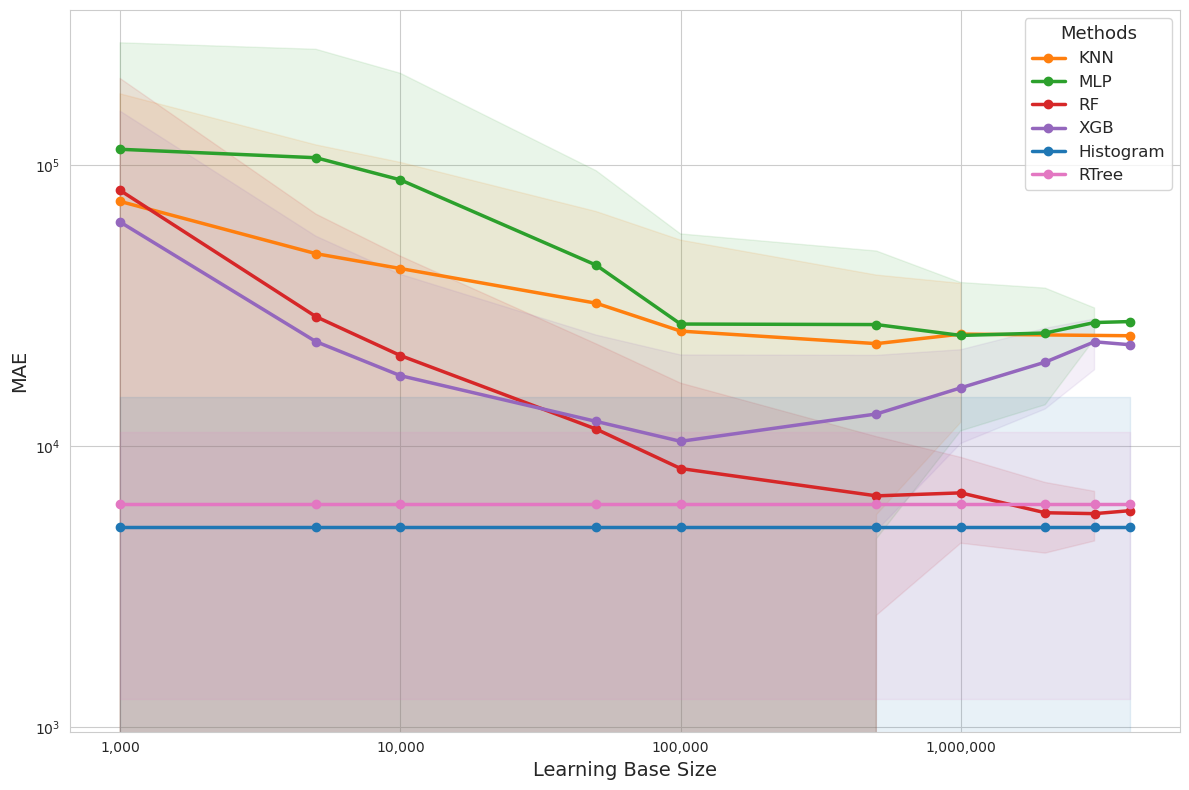

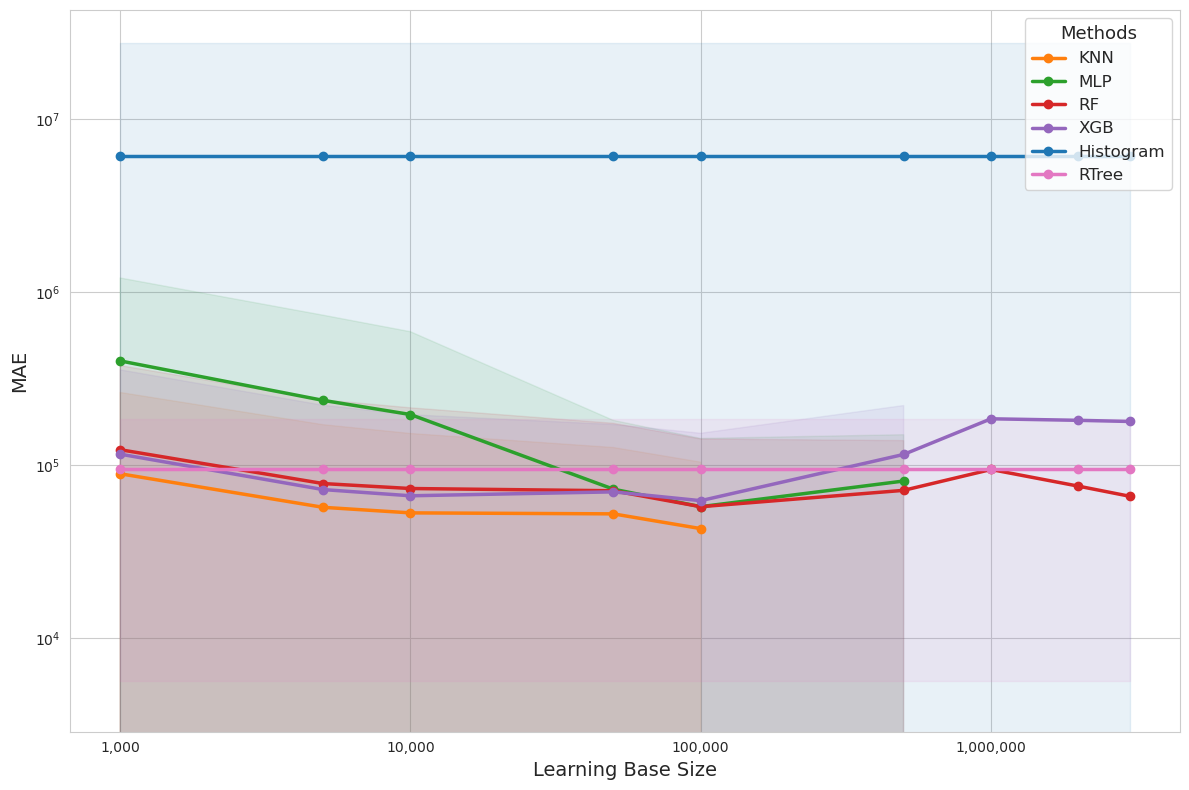

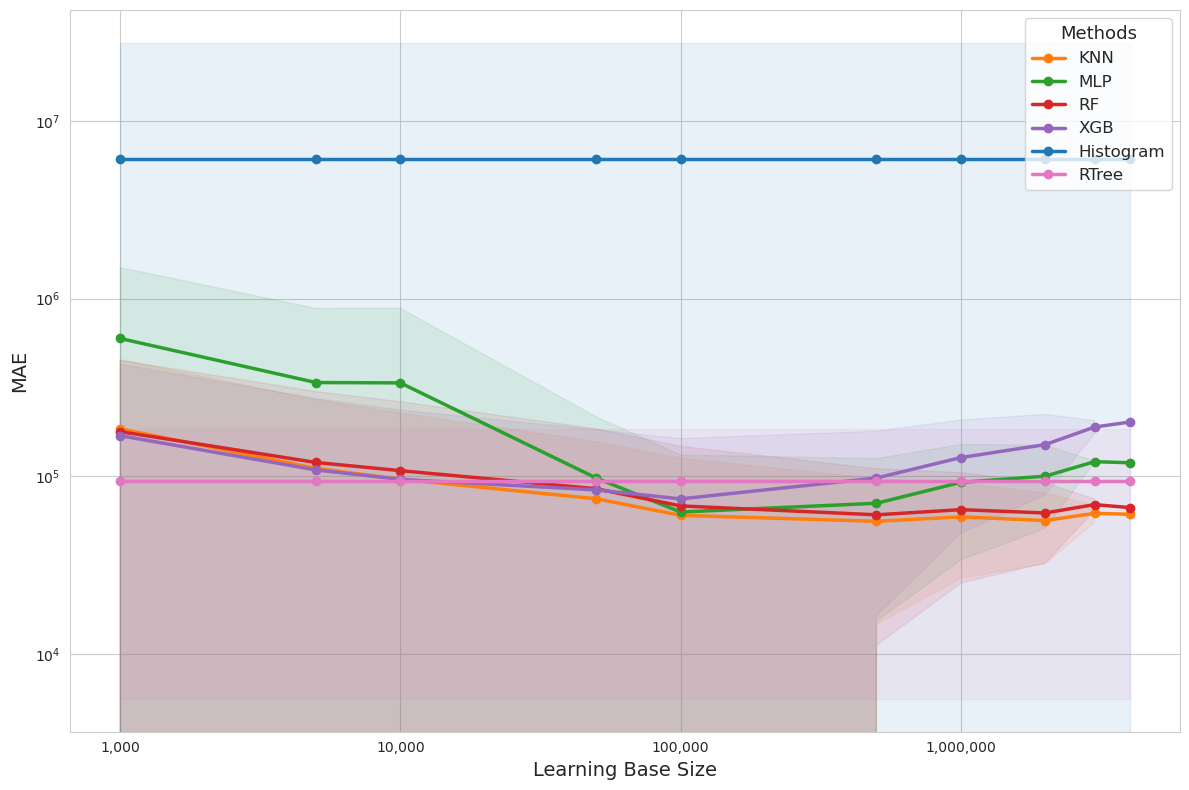

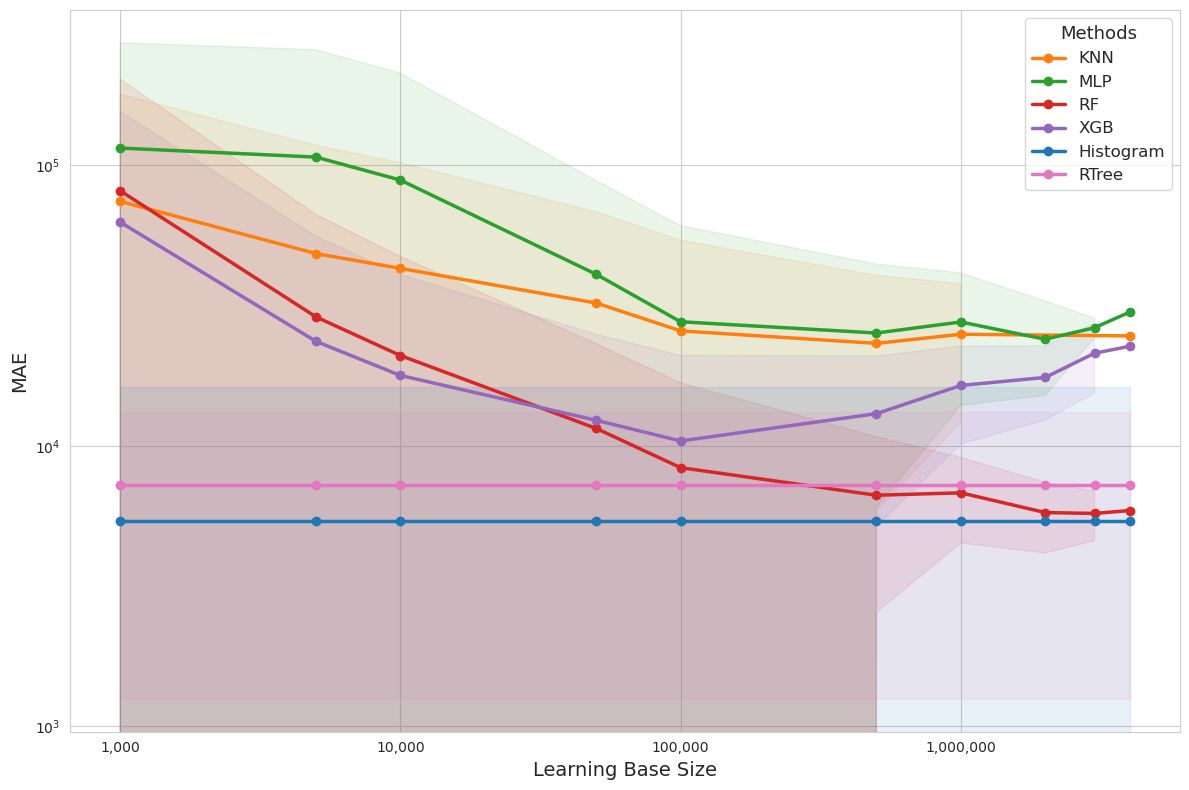

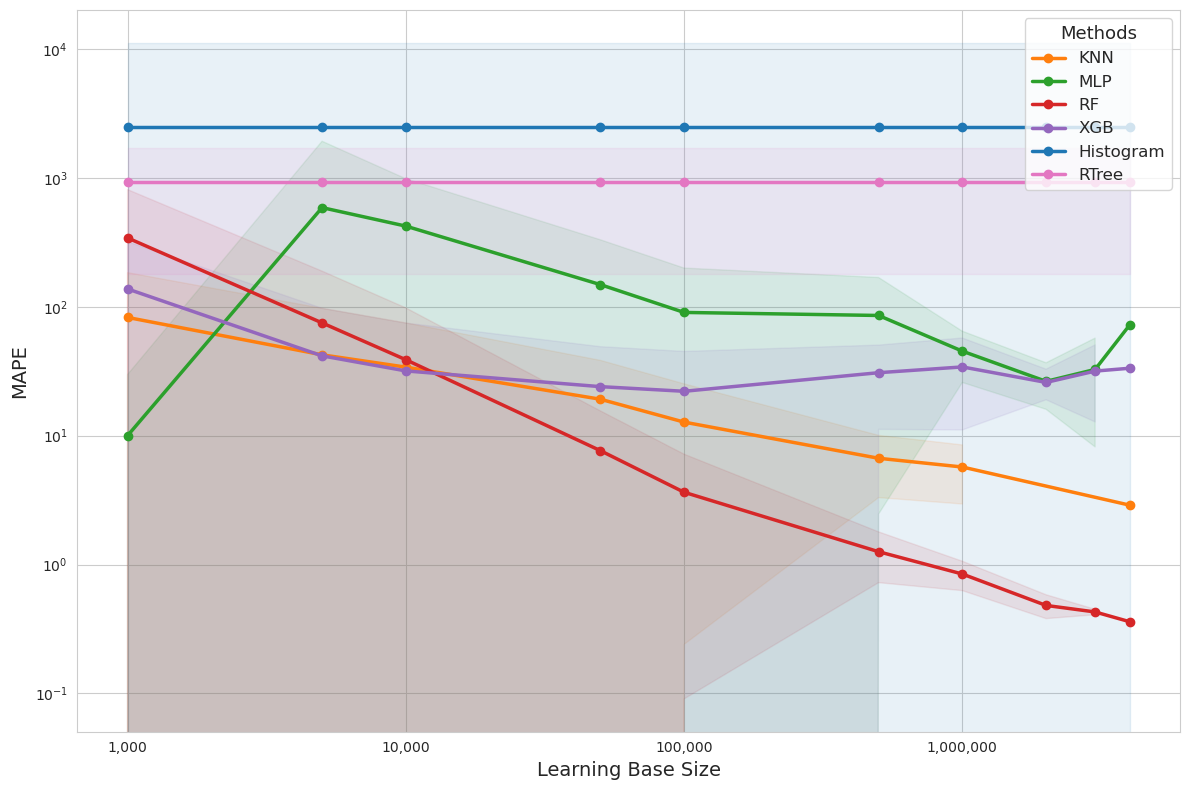

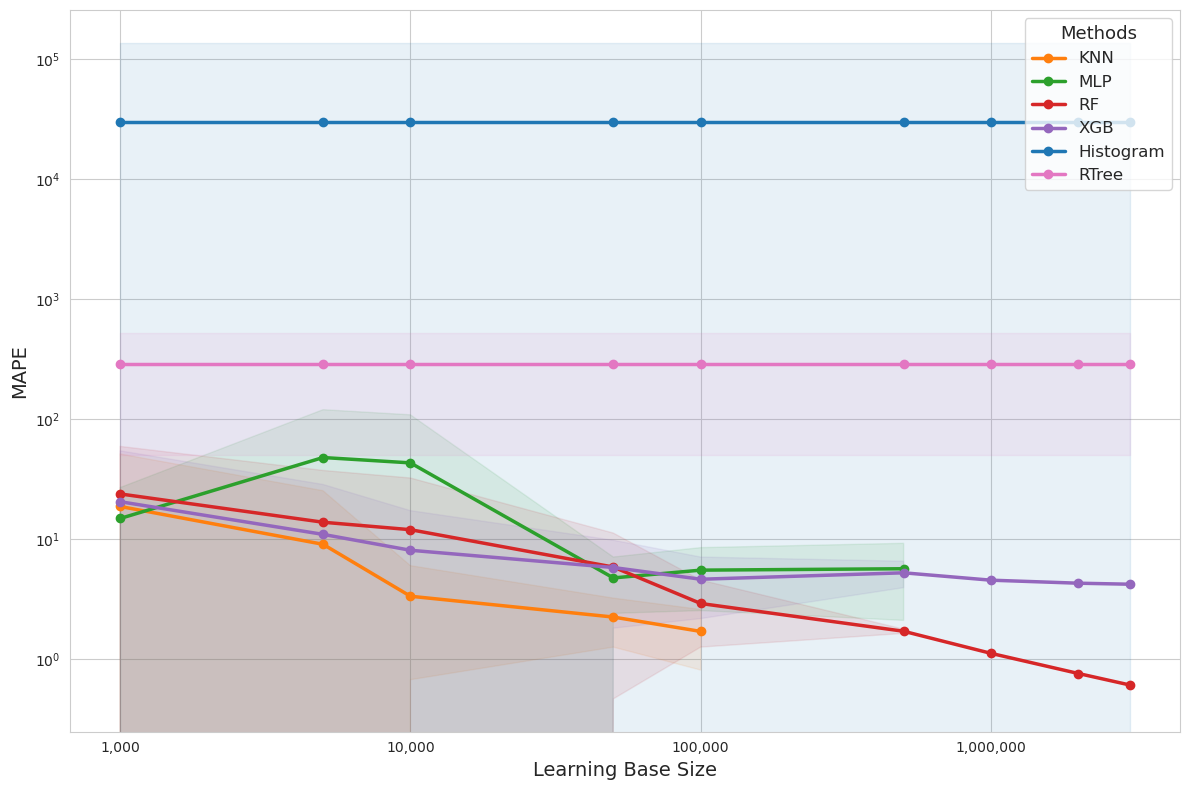

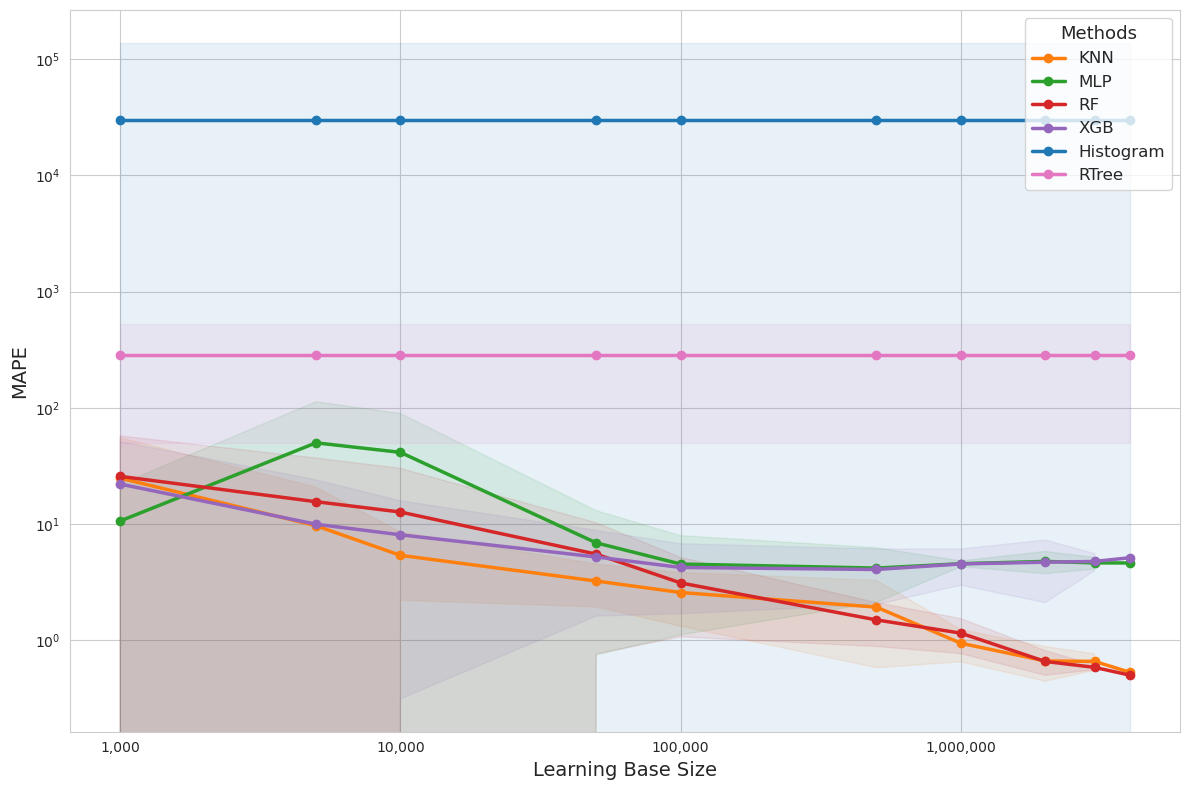

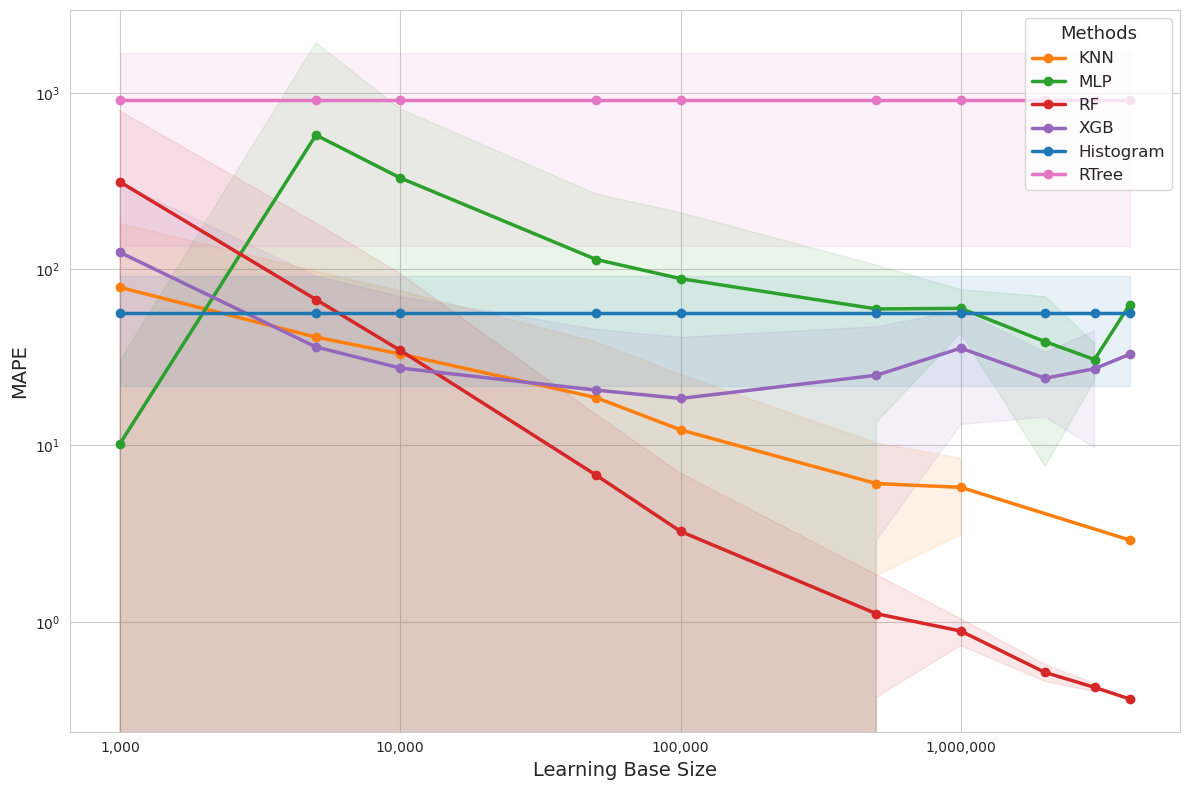

In [19]:
for metric in ['MAE', 'MAPE']:
    for filter in ['contain', 'distanceOLD', 'distance', 'intersect']:
        a, b, df = plot_method_performance_comparison_mean_std(
            f'/home/adminlias/nadir/Spatial-Selectivity-Ext/large_files/LearnedModels/{filter}/',
            metric=metric,
            save_path=f'mean_std_{filter}_{metric}_perf_sample_size.pdf',
            std_dev_alpha=0.1,
            log_scale=True,
            filter_type_=filter,
            rh_json=f'rtree_histogram.json',
            dataset_filter_type=0
        )

Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000), np.int64(4000000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000)]


Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000), np.int64(4000000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000), np.int64(4000000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000), np.int64(4000000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000), np.int64(500000), np.int64(1000000), np.int64(2000000), np.int64(3000000)

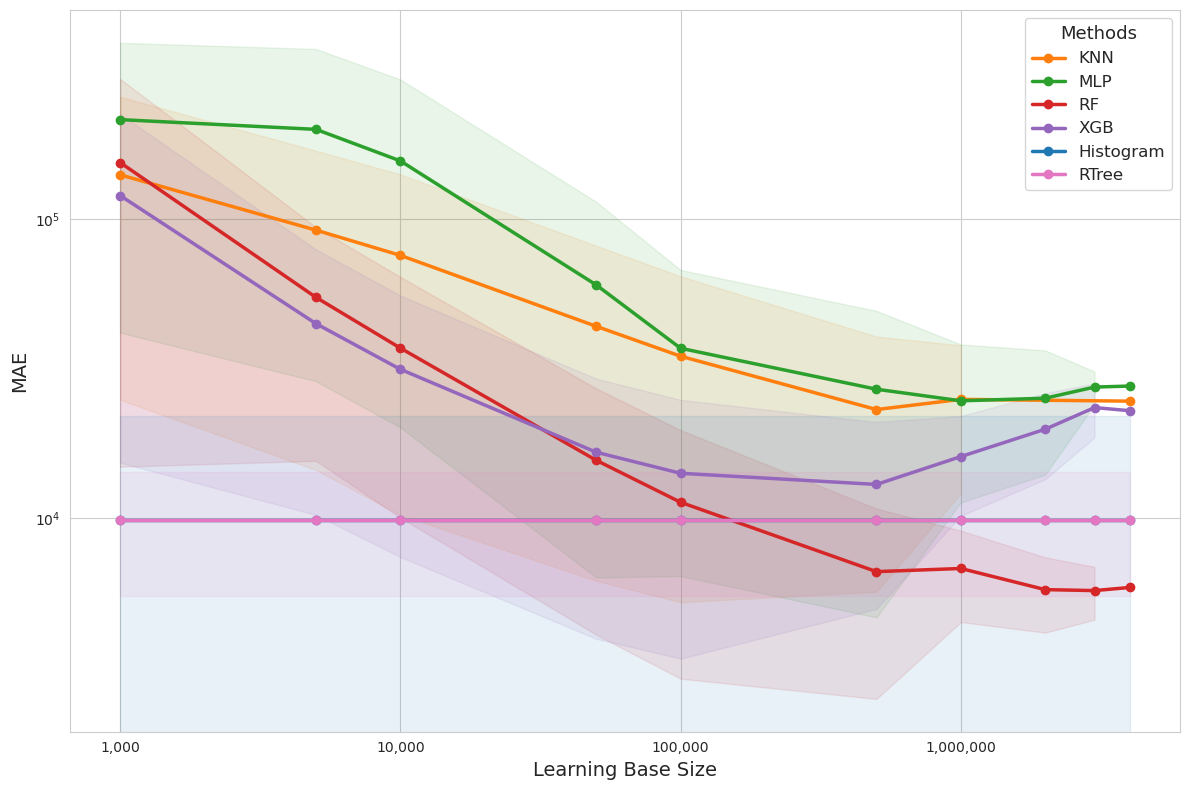

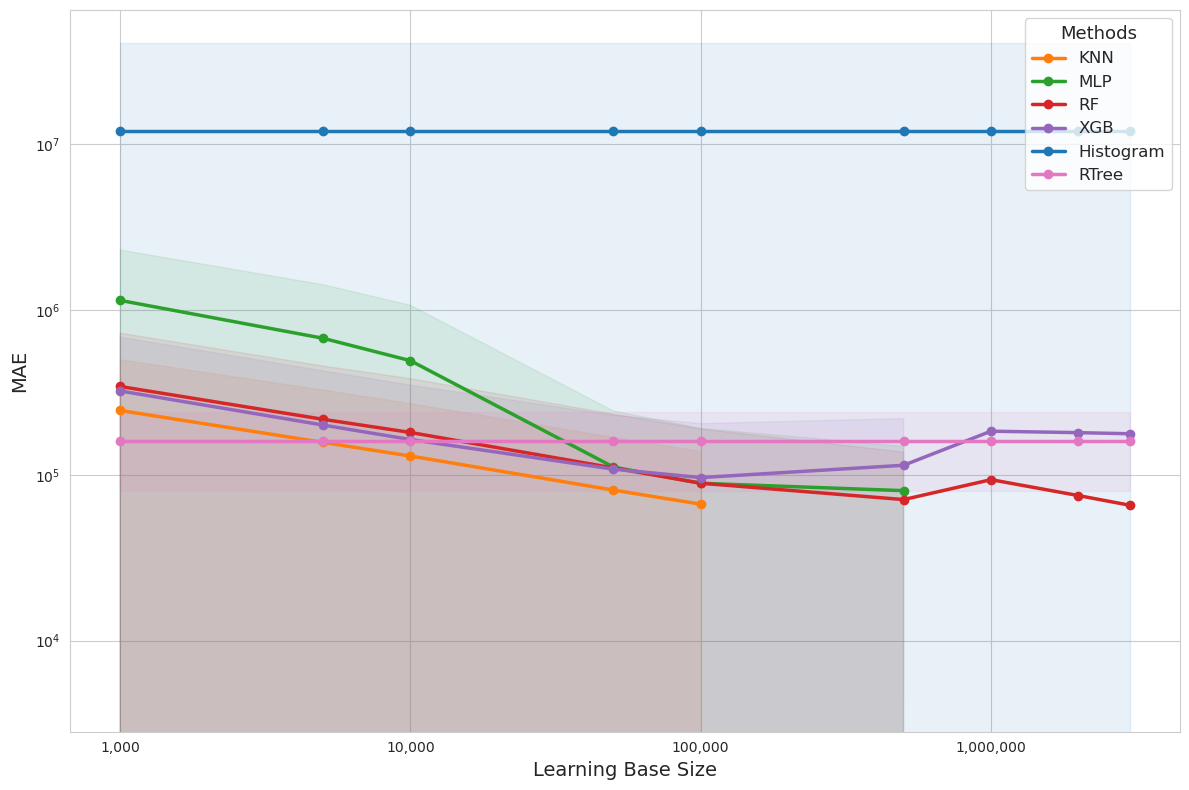

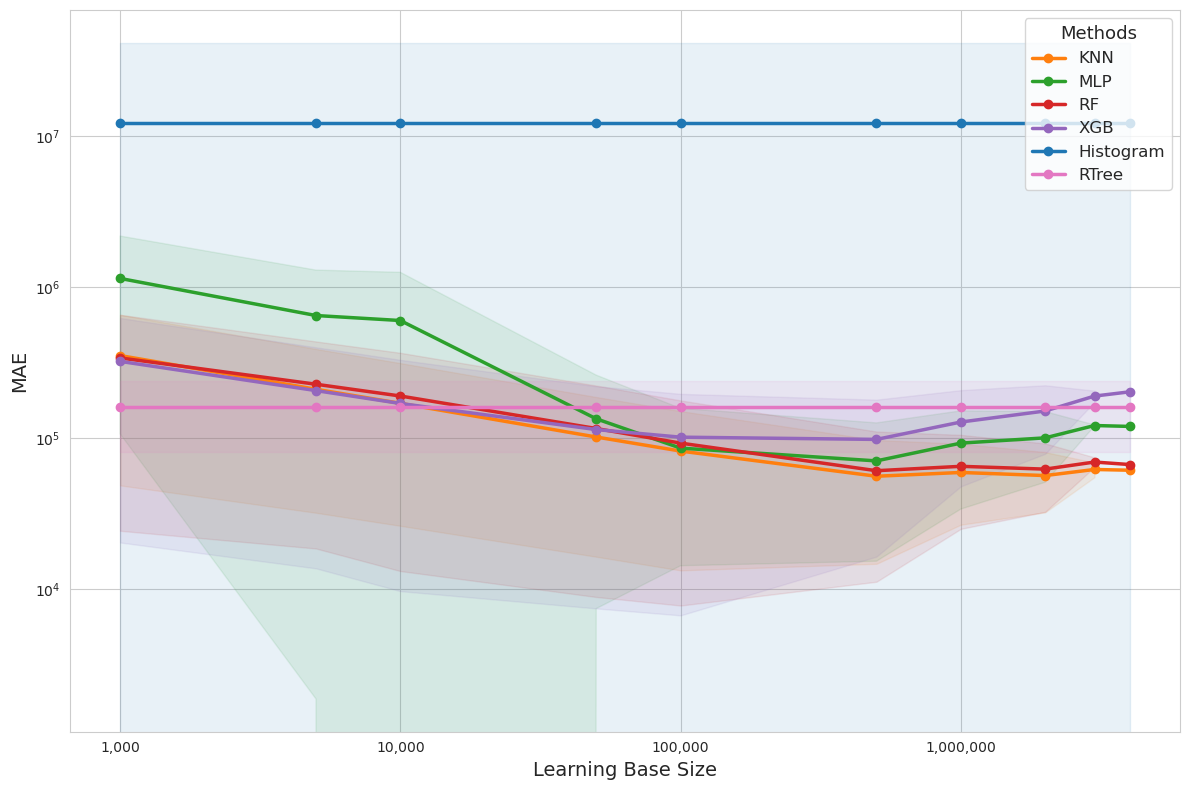

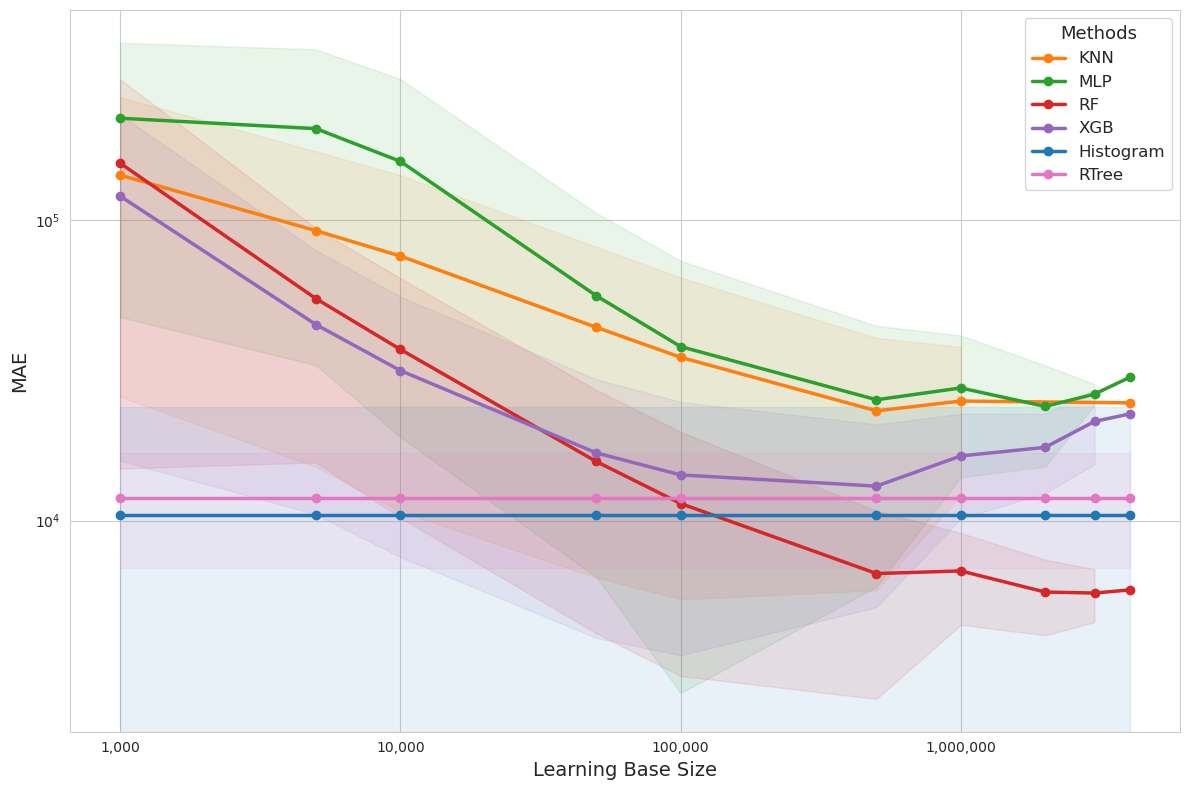

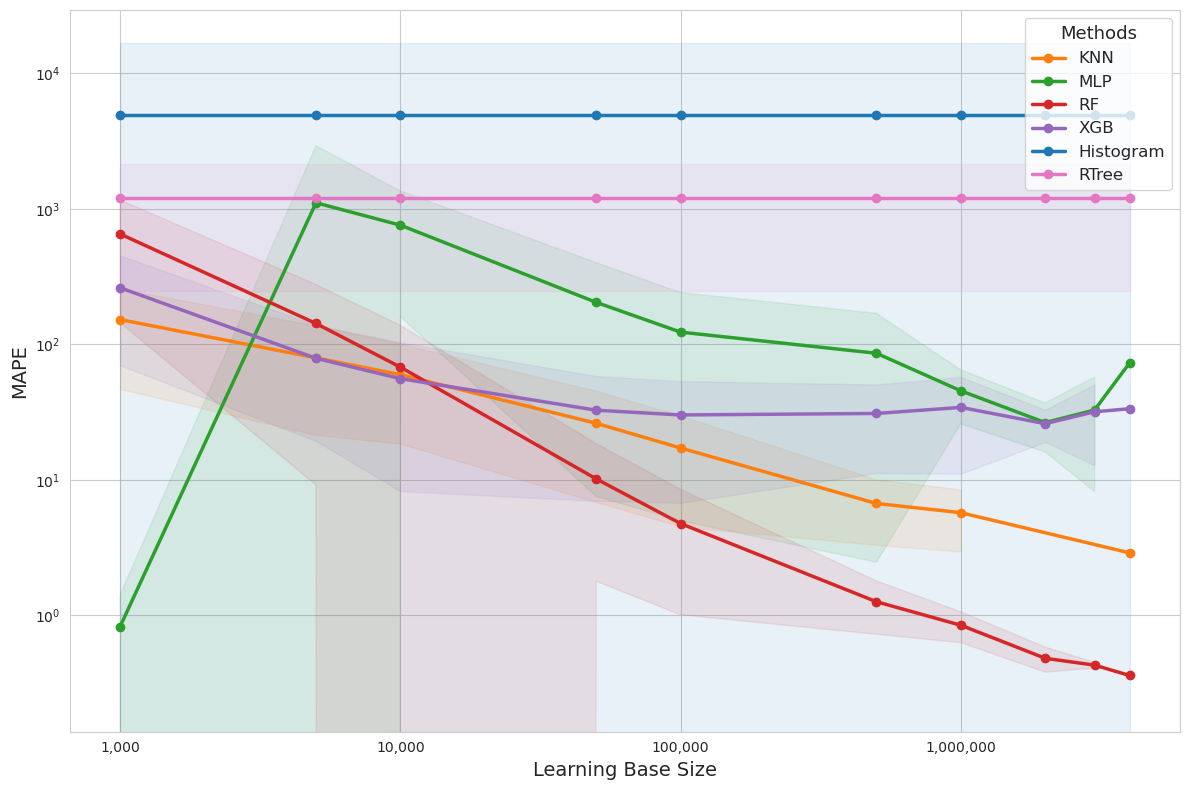

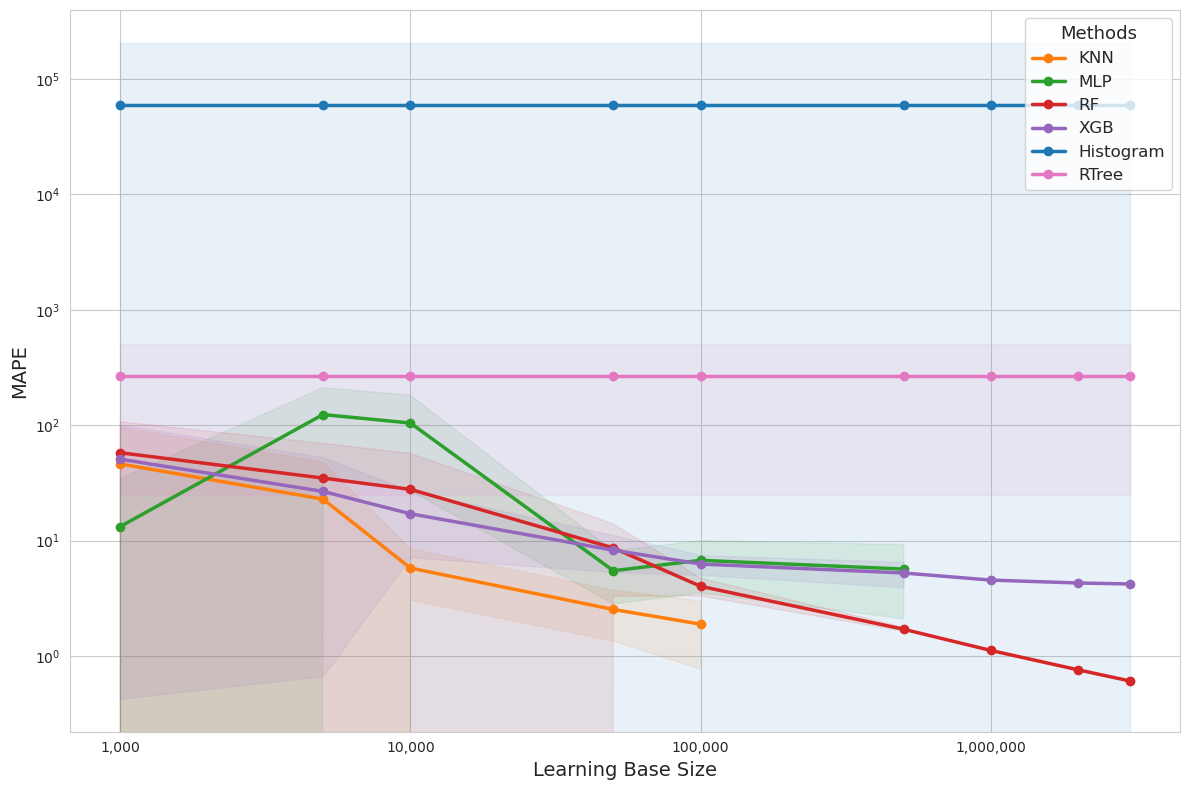

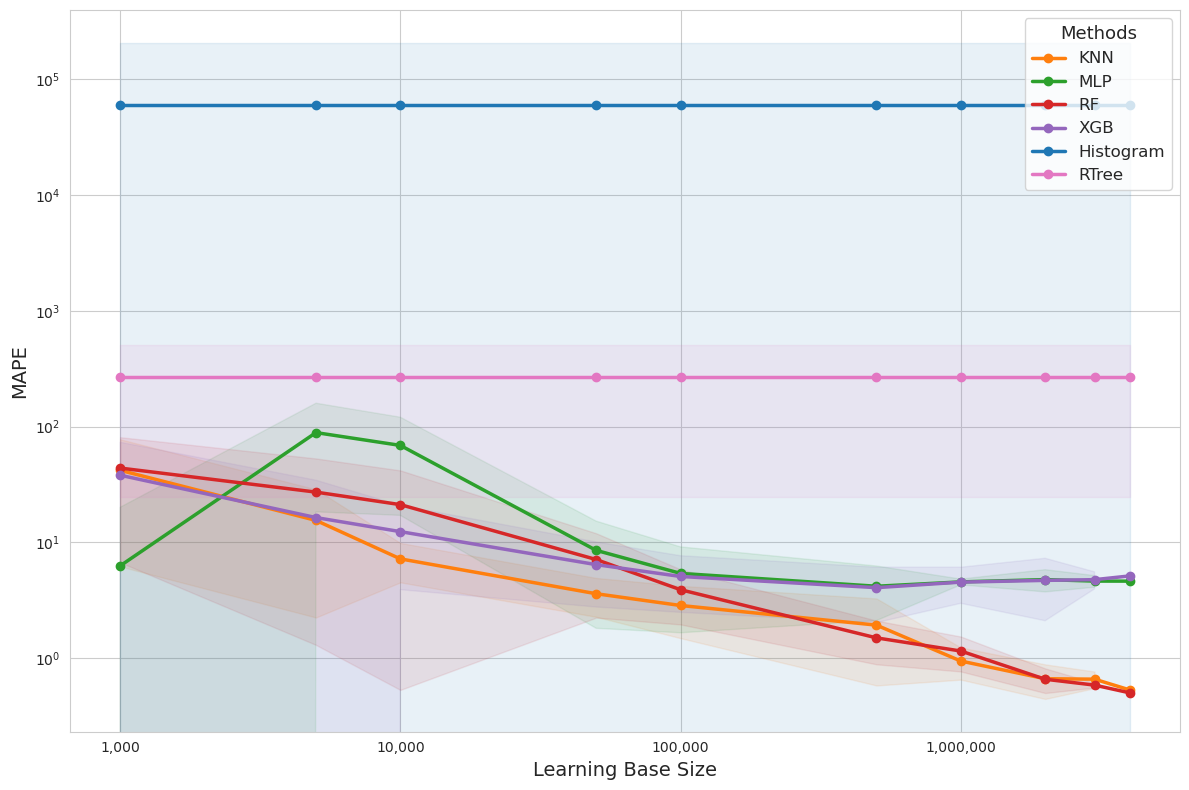

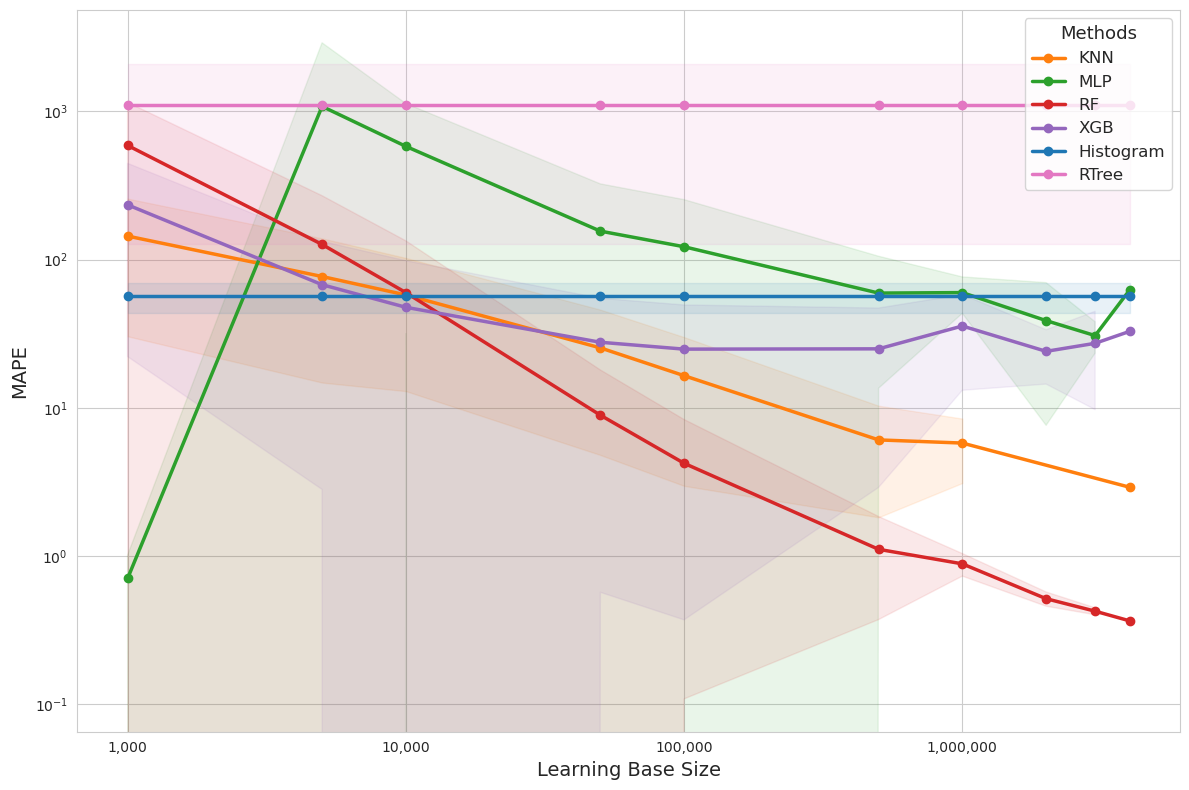

In [20]:
for metric in ['MAE', 'MAPE']:
    for filter in ['contain', 'distanceOLD', 'distance', 'intersect']:
        a, b, df = plot_method_performance_comparison_mean_std(
            f'/home/adminlias/nadir/Spatial-Selectivity-Ext/large_files/LearnedModels/{filter}/',
            metric=metric,
            save_path=f'big_mean_std_{filter}_{metric}_perf_sample_size.pdf',
            std_dev_alpha=0.1,
            log_scale=True,
            filter_type_=filter,
            rh_json=f'big_rtree_histogram.json',
            dataset_filter_type=1
        )

Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000)]


Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000)]
Using standard sample sizes: [np.int64(1000), np.int64(5000), np.int64(10000), np.int64(50000), np.int64(100000)]


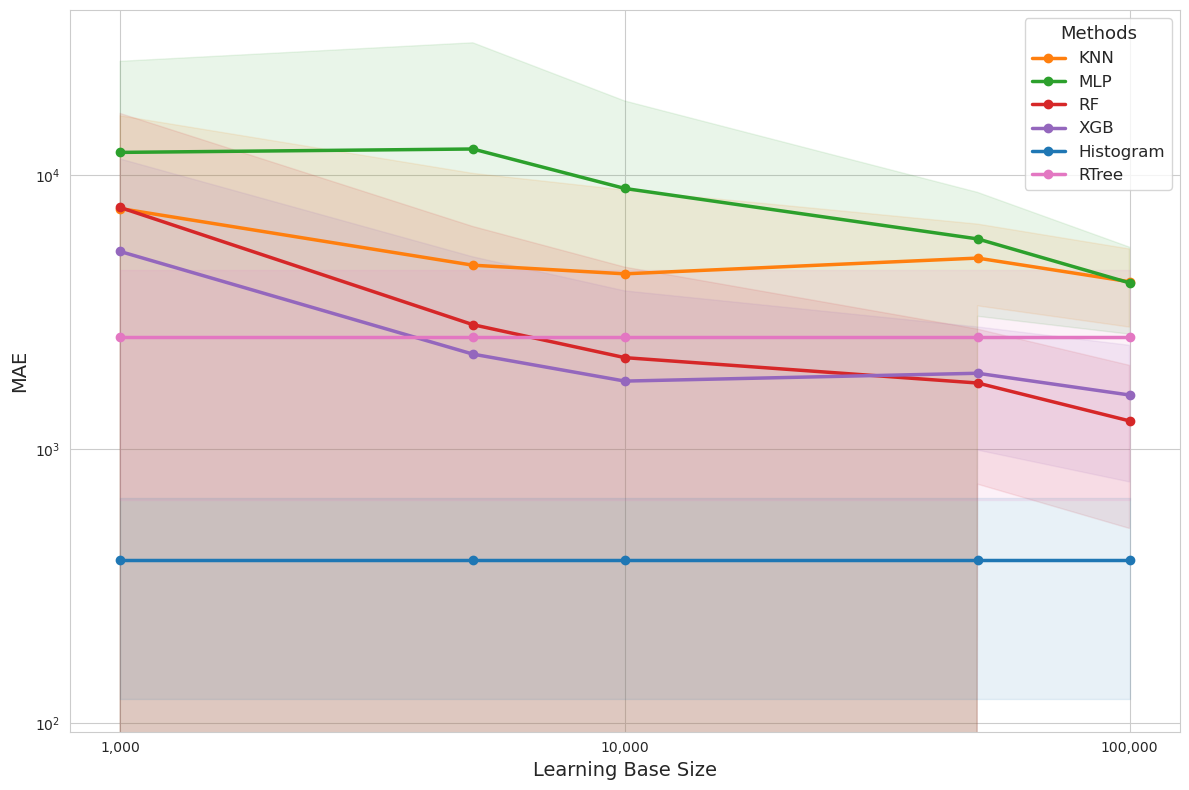

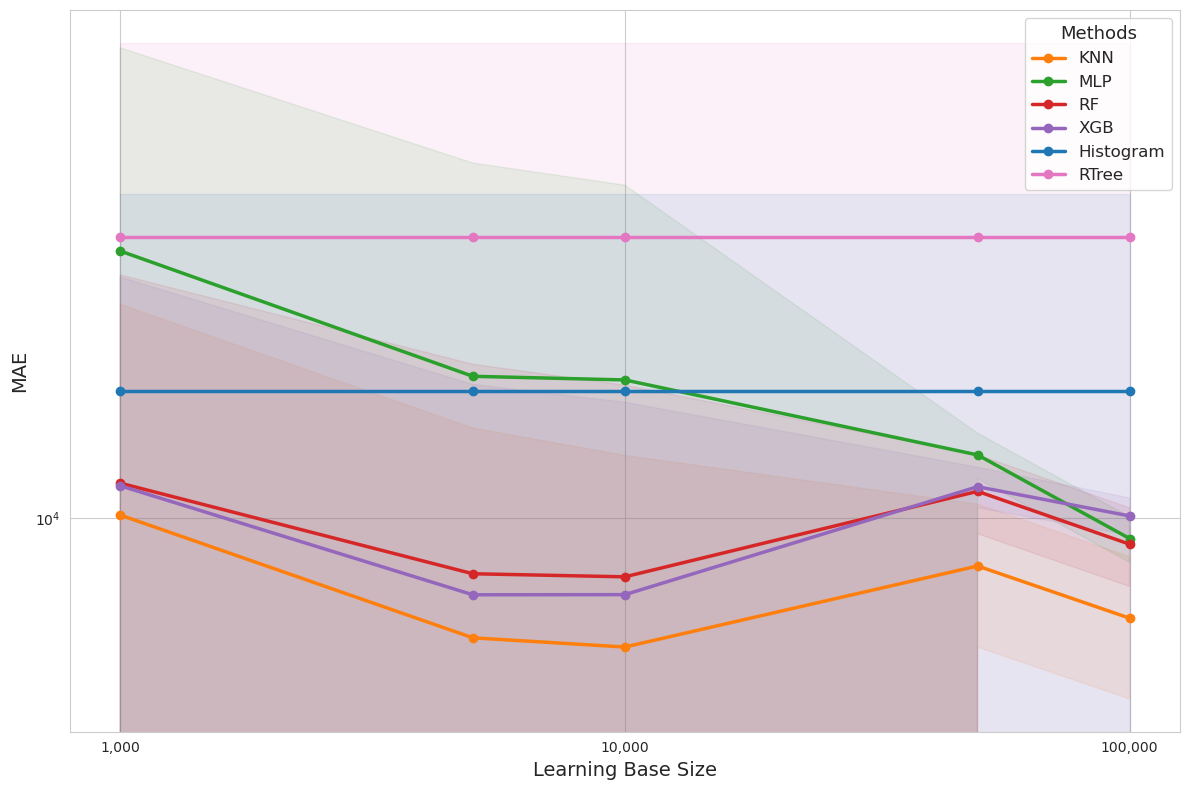

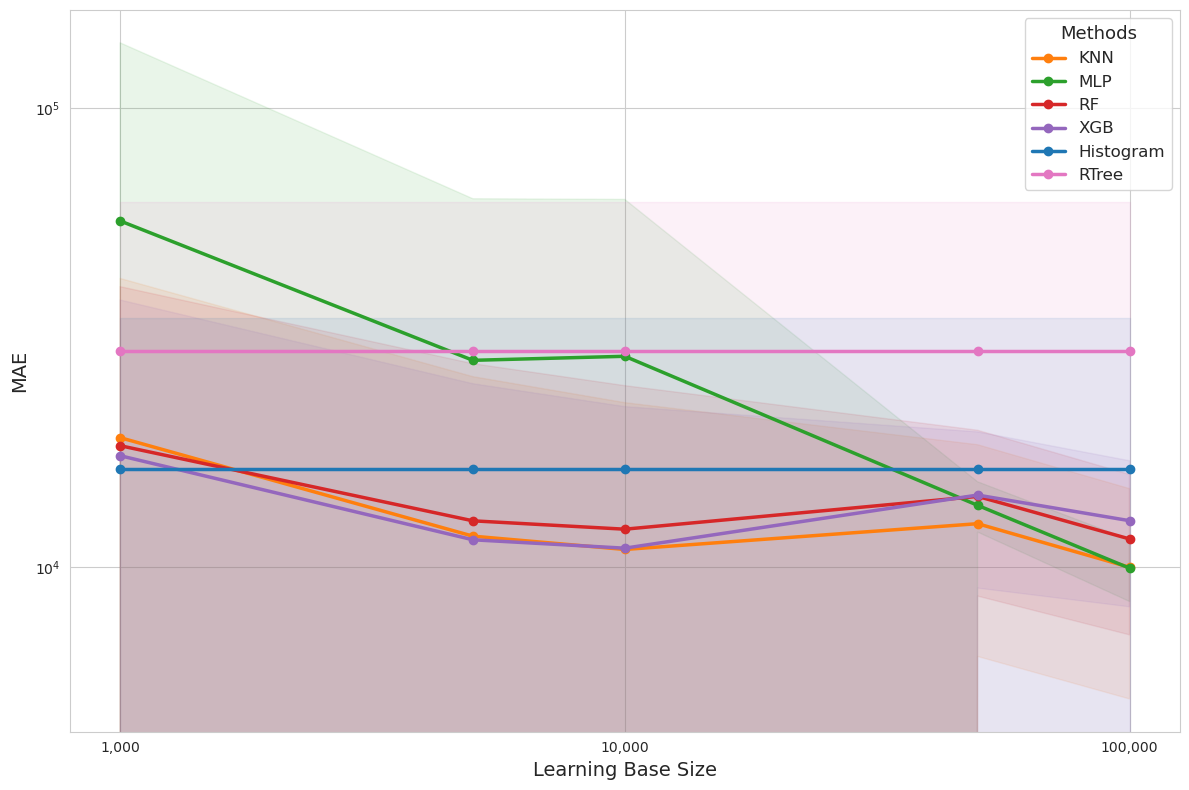

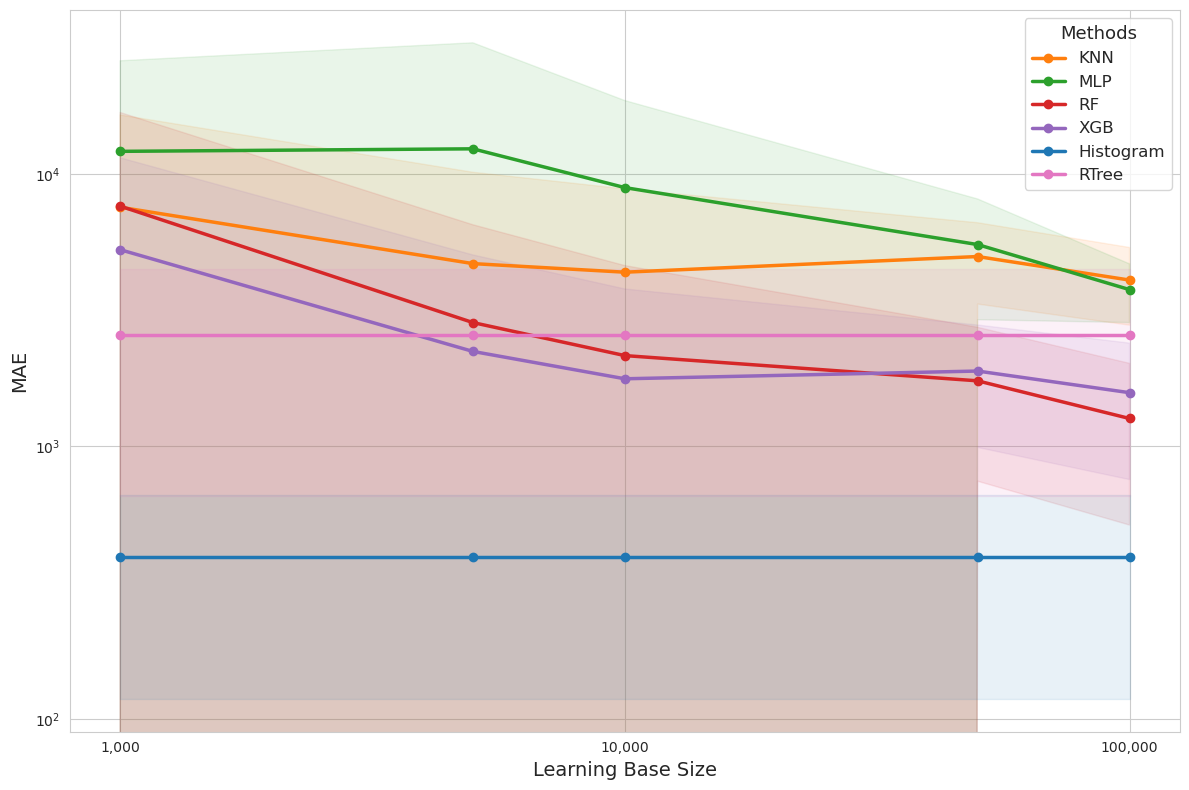

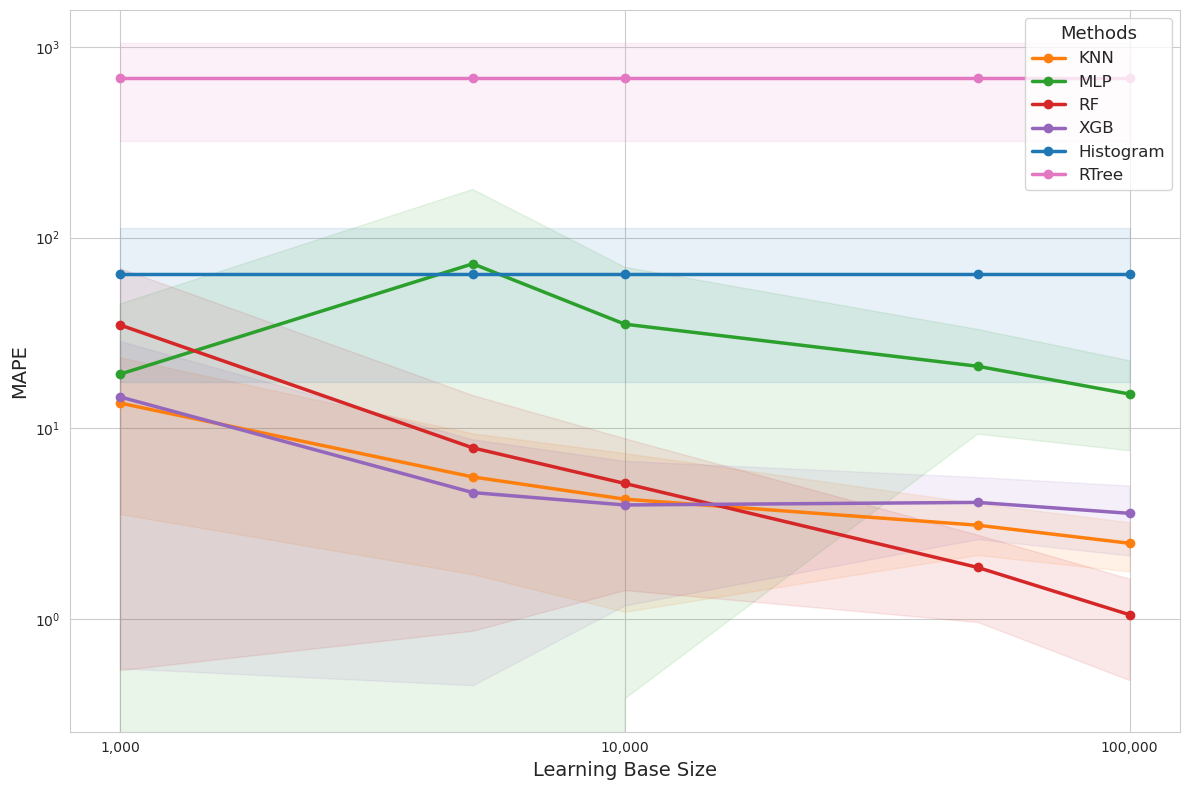

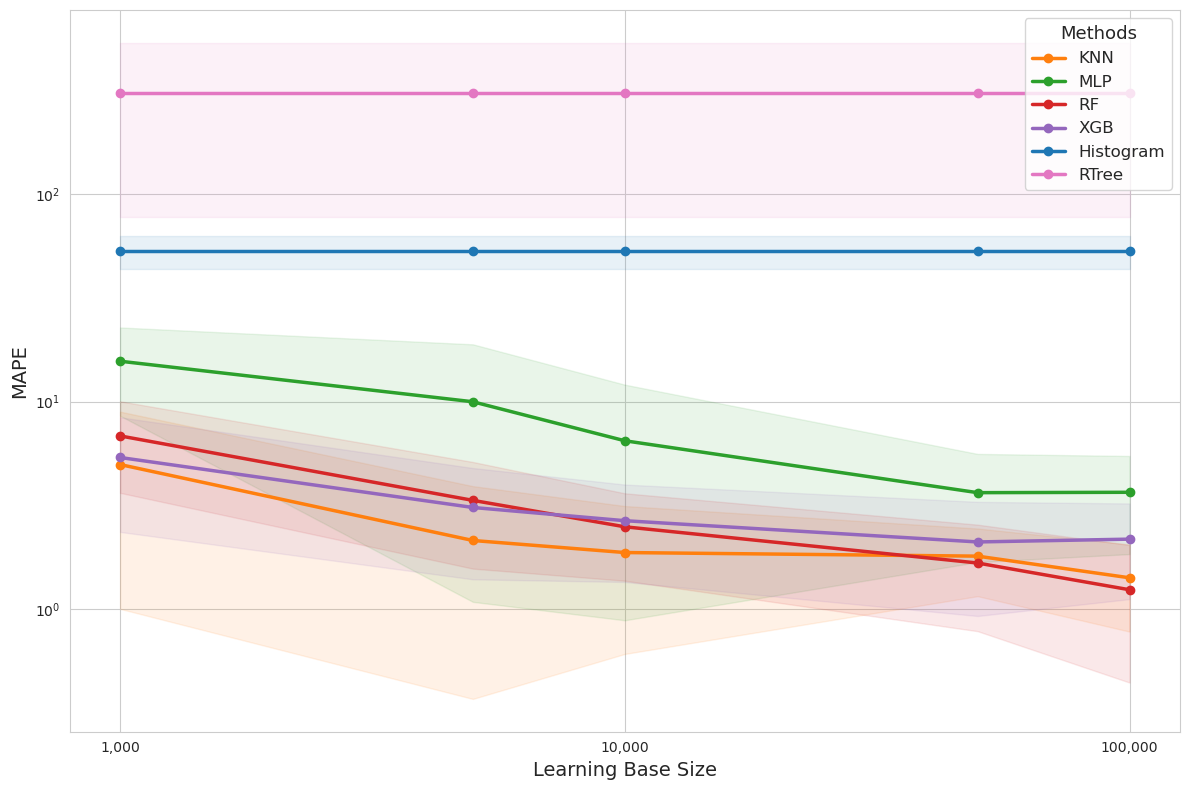

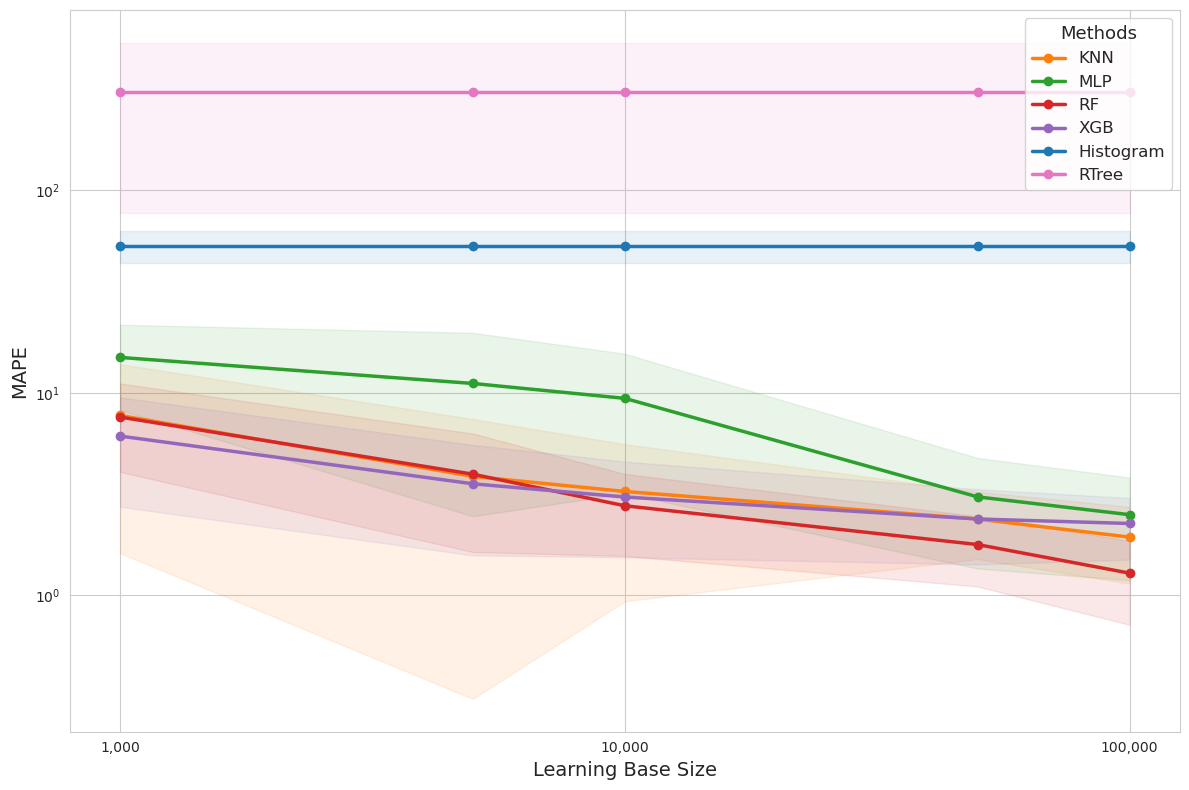

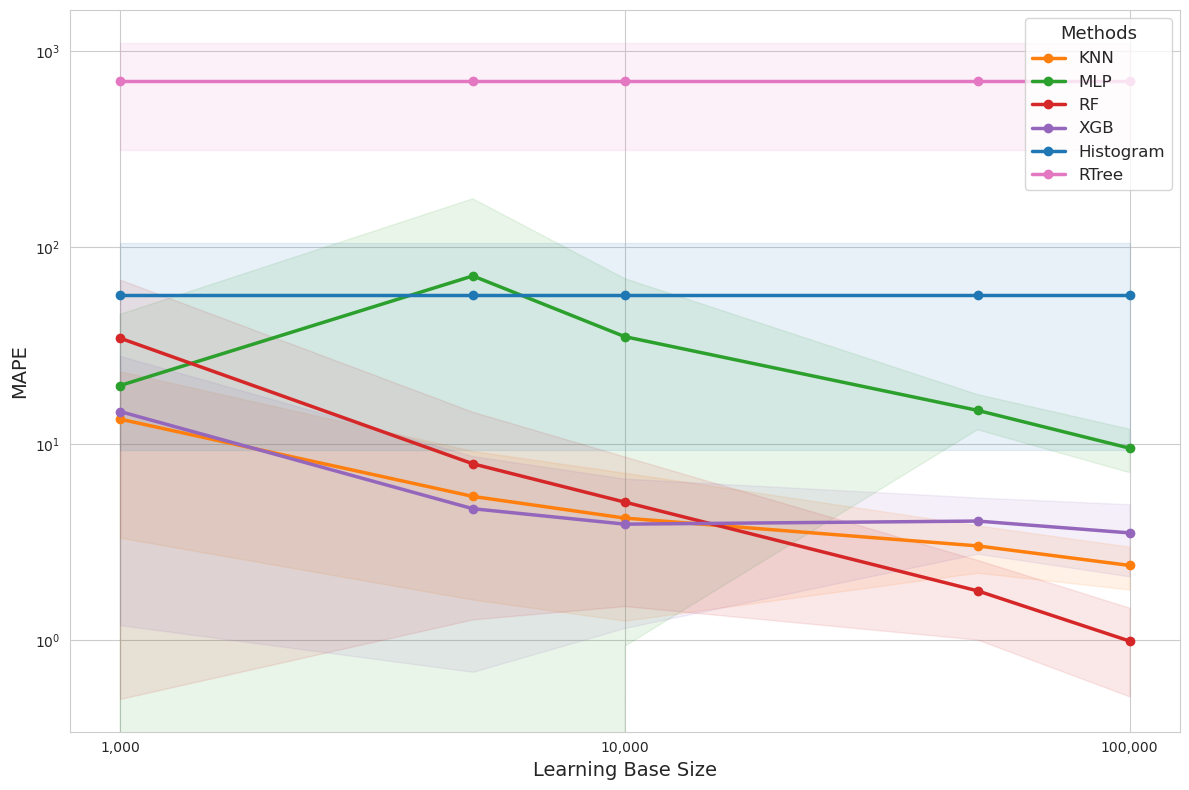

In [21]:
for metric in ['MAE', 'MAPE']:
    for filter in ['contain', 'distanceOLD', 'distance', 'intersect']:
        a, b, df = plot_method_performance_comparison_mean_std(
            f'/home/adminlias/nadir/Spatial-Selectivity-Ext/large_files/LearnedModels/{filter}/',
            metric=metric,
            save_path=f'small_mean_std_{filter}_{metric}_perf_sample_size.pdf',
            std_dev_alpha=0.1,
            log_scale=True,
            filter_type_=filter,
            rh_json=f'small_rtree_histogram.json',
            dataset_filter_type=2
        )

In [22]:
# def plot_method_performance_comparison_median_iqr(methods_dir, metric='MAE', figsize=(12, 8), 
#                                       quantile_alpha=0.2, log_scale=True,
#                                       title=None, save_path=None):
#         """
#         Create a plot comparing methods' performance across different sample sizes,
#         with variance shown as shaded areas between quantiles.
        
#         Args:
#             methods_dir: Directory containing method folders
#             metric: Performance metric to use ('MAE', 'MAPE', 'R2_Score', etc.)
#             figsize: Figure size (width, height)
#             quantile_alpha: Alpha transparency for the quantile shading
#             log_scale: Whether to use logarithmic scale for x and/or y axes
#             title: Custom title (if None, generates based on metric)
#             save_path: Path to save the figure
            
#         Returns:
#             matplotlib Figure and Axes
#         """
#         # Get all method directories
#         method_dirs = [d for d in os.listdir(methods_dir) 
#                     if os.path.isdir(os.path.join(methods_dir, d))]
        
#         # Prepare data collection
#         all_data = []
        
#         # Process each method
#         for method in method_dirs:
#             method_path = os.path.join(methods_dir, method)
#             results_file = os.path.join(method_path, 'all_results.csv')
            
#             if not os.path.exists(results_file):
#                 print(f"Warning: No all_results.csv found for method {method}")
#                 continue
            
#             # Read the method's data
#             try:
#                 df = pd.read_csv(results_file)
                
#                 # Add method column
#                 df['Method'] = method if method != 'NN' else 'MLP'
                
#                 # Append to collection
#                 all_data.append(df)
                
#             except Exception as e:
#                 print(f"Error reading data for method {method}: {e}")
        
#         if not all_data:
#             raise ValueError("No valid data found in the method directories")
        
#         # Combine all data
#         combined_df = pd.concat(all_data, ignore_index=True)
        
#         # Filter to include only standard sample sizes
#         filtered_df = combined_df[combined_df['Sample_Size'].apply(is_standard_sample_size)]
        
#         if filtered_df.empty:
#             print("Warning: No data matches standard sample sizes. Using all available sizes.")
#             print(f"Available sizes: {sorted(combined_df['Sample_Size'].unique())}")
#             filtered_df = combined_df
#         else:
#             print(f"Using standard sample sizes: {sorted(filtered_df['Sample_Size'].unique())}")
        
#         # Group by Method and Sample_Size to get median and quantiles
#         grouped = filtered_df.groupby(['Method', 'Sample_Size']).agg({
#             metric: ['median', lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.75)]
#         }).reset_index()
        
#         # Flatten the multi-level columns
#         grouped.columns = ['Method', 'Sample_Size', f'Median_{metric}', f'Q25_{metric}', f'Q75_{metric}']
        
#         # Create the plot
#         plt.figure(figsize=figsize)
#         sns.set_style('whitegrid')
        
#         # Create a colorful palette
#         methods = grouped['Method'].unique()
#         palette = sns.color_palette('tab10', n_colors=len(methods))
        
#         # Plot for each method
#         for i, method in enumerate(methods):
#             # if method != 'XGB': continue
#             if method == 'DT': continue

#             method_data = grouped[grouped['Method'] == method]
            
#             # Sort by sample size
#             method_data = method_data.sort_values('Sample_Size')
            
#             # Plot line and median
#             plt.plot(method_data['Sample_Size'], method_data[f'Median_{metric}'], 
#                     marker='o', linewidth=2.5, label=method, color=palette[i])
            
#             # Add shaded area between quantiles
#             lower = method_data[f'Q25_{metric}']
#             upper = method_data[f'Q75_{metric}']
            
#             # Ensure lower bound isn't negative for metrics where that doesn't make sense
#             if metric in ['MAE', 'MAPE']:
#                 lower = np.maximum(lower, 0)
                
#             plt.fill_between(method_data['Sample_Size'], lower, upper, 
#                             alpha=quantile_alpha, color=palette[i])
        
#         # Set logarithmic scale if requested
#         if log_scale:
#             plt.xscale('log')
#             # if metric in ['MAE', 'MAPE']:  # Only use log y-scale for error metrics
#             #     plt.yscale('log')
        
#         # Set labels and title
#         plt.xlabel('Sample Size', fontsize=14)
#         plt.ylabel(metric, fontsize=14)
        
#         # if title is None:
#         #     title = f"Performance Comparison ({metric}) - Median with IQR"
#         plt.title(title, fontsize=16)
        
#         # Format x-axis to show clean sample size labels
#         plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
        
#         # Add legend in the upper right inside the plot
#         plt.legend(title="Methods", loc="upper right", fontsize=12, title_fontsize=13)
        
#         # Improve layout
#         plt.tight_layout()
        
#         # Save the figure if a save path is provided
#         if save_path:
#             plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
#         # Return figure for further customization
#         return plt.gcf(), plt.gca(), grouped

In [23]:
# # for metric in ['MAE', 'MAPE']:
#     for filter in ['contain', 'distanceOLD', 'intersect']:
#         a, b, df = plot_method_performance_comparison_median_iqr(
#             f'/home/adminlias/nadir/Spatial-Selectivity-Ext/large_files/LearnedModels/{filter}/',
#             metric=metric,
#             save_path=f'median_iqr_{filter}_{metric}_perf_sample_size.pdf',
#             quantile_alpha=0.1,
#             log_scale=True,
#         )

In [24]:
# import json
# import numpy as np

# def process_json_data(file_path):
#     # Load JSON data
#     with open(file_path, 'r') as f:
#         data = json.load(f)
    
#     # Collect data by filters and methods
#     collected_data = {}
#     target_methods = ["Histogram", "RTree"]
    
#     # First pass: identify all filters and initialize data structure
#     for dataset_name, dataset in data.items():
#         if dataset_name not in big_datasets:
#             continue
#         for method_name, method_data in dataset.items():
#             if method_name not in target_methods:
#                 continue
                
#             for filter_name, metrics in method_data.items():
#                 if filter_name not in collected_data:
#                     collected_data[filter_name] = {
#                         method: {"mae": [], "mape": []} for method in target_methods
#                     }
                
#                 # Collect MAE and MAPE values
#                 if "mae" in metrics and "mape" in metrics:
#                     collected_data[filter_name][method_name]["mae"].append(metrics["mae"])
#                     collected_data[filter_name][method_name]["mape"].append(metrics["mape"])
    
#     # Calculate statistics and build result
#     result = {}
#     for filter_name, methods in collected_data.items():
#         result[filter_name] = {}
#         for method_name, metrics in methods.items():
#             # Only include method if we have data for it
#             if metrics["mae"] or metrics["mape"]:
#                 result[filter_name][method_name] = {
#                     "avg_mae": np.mean(metrics["mae"]) if metrics["mae"] else None,
#                     "std_mae": np.std(metrics["mae"]) if len(metrics["mae"]) > 1 else 0,
#                     "avg_mape": np.mean(metrics["mape"]) if metrics["mape"] else None,
#                     "std_mape": np.std(metrics["mape"]) if len(metrics["mape"]) > 1 else 0
#                 }
    
#     return result

# result = process_json_data("/home/adminlias/nadir/Spatial-Selectivity-Ext/analyze_results/model_comparison copy.json")
# print(json.dumps(result, indent=2))

# with open("big_rtree_histogram.json", 'w') as f:
#     f.write(json.dumps(result, indent=2))